In [ ]:
!wget https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/resnet50_coco_best_v2.0.1.h5
!wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5

In [55]:
import aiohttp

async def get_http(url):
    async with aiohttp.ClientSession() as ua:
        async with ua.get(url) as res:
            res.raise_for_status()
            return await res.read()

In [10]:
import tensorflow as tf, keras

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

keras.backend.tensorflow_backend.set_session(get_session())

In [11]:
from keras_retinanet import models


model = models.load_model('resnet50_coco_best_v2.1.0.h5', backbone_name='resnet50')

(1160, 1880, 3)


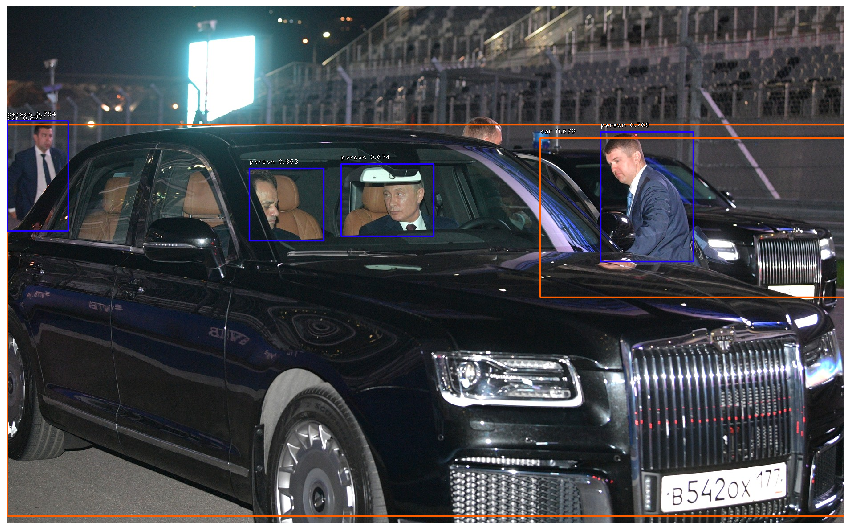

In [66]:
%matplotlib inline

from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2
import numpy as np


url = 'https://pbs.twimg.com/media/DN4bf7SXUAE_JFI.jpg'
url = 'http://static.kremlin.ru/media/events/photos/big2x/rCQOEBamWfK5CrpeW17SHVJLNNEvHmKm.jpg'
buf = await get_http(url)

img = np.asarray(bytearray(buf), dtype=uint8)
img = cv2.imdecode(img, cv2.IMREAD_UNCHANGED)
# img = read_image_bgr('Putin-Bear.jpg')
draw = img.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

img = preprocess_image(img)
img, scale = resize_image(img)
boxes, scores, labels = model.predict_on_batch(np.expand_dims(img, axis=0))
boxes /= scale  # correct for image scale

for box,score,label in zip(boxes[0], scores[0], labels[0]):
    if score < 0.6:
        break

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    # https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb
    caption = "{} {:.3f}".format({ 0: 'person', 2: 'car', 21: 'bear' }[label], score)
    draw_caption(draw, b, caption)

    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

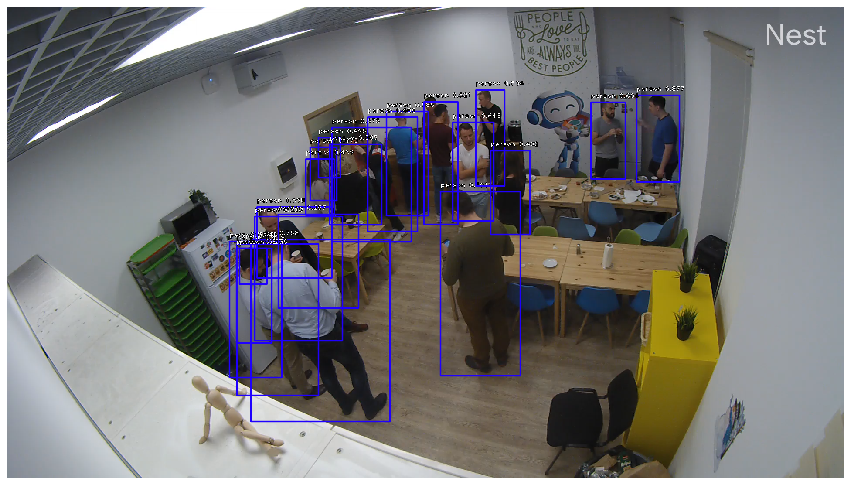

In [17]:
%matplotlib inline

from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2
import numpy as np
import ffmpeg

stream = ffmpeg.input('https://stream-us1-bravo.dropcam.com/nexus_aac/09e4ddd9c3e14cc39d08fe50111e133c/chunklist_w534399443.m3u8?public=8CgnTt6x2U')


out, _ = stream.output('pipe:', vframes=1, format='rawvideo', pix_fmt='bgr24').run(capture_stdout=True)
img = np.frombuffer(out, np.uint8).reshape([-1, 1080, 1920, 3])[0]  # format='image2', vcodec='mjpeg'

# img = cv2.imdecode(img, cv2.IMREAD_UNCHANGED)
draw = img.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

img = preprocess_image(img)
img, scale = resize_image(img)
boxes, scores, labels = model.predict_on_batch(np.expand_dims(img, axis=0))
boxes /= scale  # correct for image scale

for box,score,label in zip(boxes[0], scores[0], labels[0]):
    if score < 0.25 or label != 0:
        continue

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    # https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb
    caption = "{} {:.3f}".format({ 0: 'person', 2: 'car', 21: 'bear', 56: 'chair' }[label], score)
    draw_caption(draw, b, caption)



plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()


In [5]:
import numpy as np
import ffmpeg
probe = ffmpeg.probe('https://stream-us1-bravo.dropcam.com/nexus_aac/09e4ddd9c3e14cc39d08fe50111e133c/chunklist_w534399443.m3u8?public=8CgnTt6x2U')
video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])

width, height

(1920, 1080)

[stream|starred](https://github.com/kkroening/ffmpeg-python/blob/master/examples/ffmpeg-numpy.ipynb)

#### TODO ####
- https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_tutorials.html

